In [1]:
import matplotlib.pyplot as plt

import torch

from torchvision.datasets import CelebA
from torchvision import transforms

from torch.utils.data import DataLoader

from glow import GLOW
import normflows as nf

import torchvision as tv
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
transform = transforms.Compose([
        transforms.ToTensor(),
    transforms.Resize(96),
    transforms.CenterCrop(96),
])

train_data = CelebA(root='./data', transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, drop_last=True)

flow = GLOW(3, 32, (3, 96, 96), 40, 256)
flow.model.load('models/glow/glow_celeba_3_32_256_50000.pt')

Files already downloaded and verified


/home/mando/glime/.venv/lib/python3.10/site-packages/torch/_tensor.py:791: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with
LU, pivots, info = torch.linalg.lu_factor_ex(A, compute_pivots) (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1984.)
  LU, pivots, infos = torch._lu_with_info(
/home/mando/glime/.venv/lib/python3.10/site-packages/normflows/core.py:632: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURI

In [87]:
n = 0
bpd_cum = 0
with torch.no_grad():
    for i, (x, y) in enumerate(iter(train_loader)):
        nll = flow.model(x.to('cuda:1'), y.float().to('cuda:1'))
        nll_np = nll.cpu().numpy() 
        bpd_cum += np.nansum(nll_np / np.log(2) / np.prod((3, 96, 96)) + 8)
        n += len(x) - np.sum(np.isnan(nll_np))
        
        if i >= 100:
            break
        
    print('Bits per dim: ', bpd_cum / n)

Bits per dim:  1.6792322172976957


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003166616..1.1206094].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02665016..1.0466158].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0054449737..1.0586092].


Text(0.5, 0.98, 'Manipulating latent space')

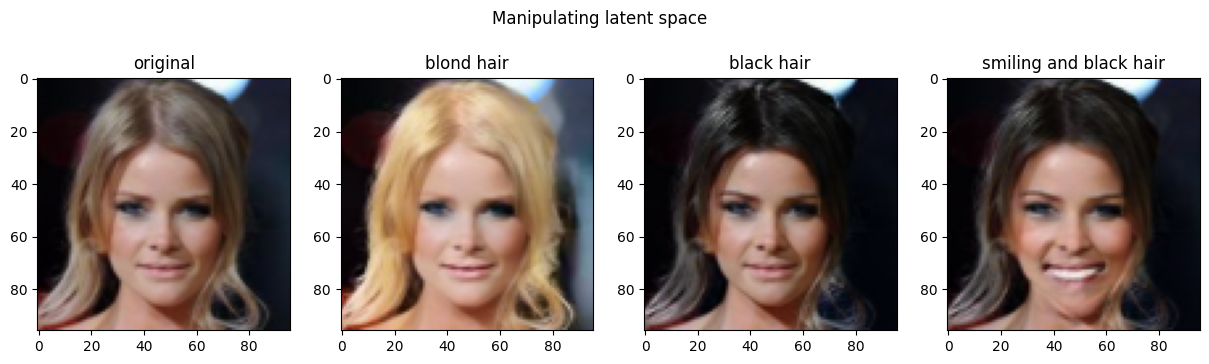

In [497]:
import pickle
import copy

latent_manipulators = pickle.load(open('latent_manipulators.pkl', 'rb'))

sample = train_data[9][0].unsqueeze(0).to('cuda:1')
latent1 = flow.to_latent(sample)
latent2 = flow.to_latent(sample)
latent3 = flow.to_latent(sample)
latent1[0] = latent1[0] + 1.5 * latent_manipulators[9].to('cuda:1')
latent2[0] = latent2[0] + 1.5 * latent_manipulators[8].to('cuda:1')
latent3[0] = latent3[0] + 1.5 * latent_manipulators[31].to('cuda:1')
latent3[0] = latent3[0] + 1.5 * latent_manipulators[8].to('cuda:1')
recon1 = flow.to_image(latent1)
recon2 = flow.to_image(latent2)
recon3 = flow.to_image(latent3)

plt.figure(figsize=(15, 4))
plt.subplot(1, 4, 1)
plt.imshow(sample[0].detach().cpu().numpy().transpose(1, 2, 0))
plt.title('original')

plt.subplot(1, 4, 2)
plt.imshow(recon1[0][0].detach().cpu().numpy().transpose(1, 2, 0))
plt.title('blond hair')

plt.subplot(1, 4, 3)
plt.imshow(recon2[0][0].detach().cpu().numpy().transpose(1, 2, 0))
plt.title('black hair')

plt.subplot(1, 4, 4)
plt.imshow(recon3[0][0].detach().cpu().numpy().transpose(1, 2, 0))
plt.title('smiling and black hair')

plt.suptitle('Manipulating latent space')